In [3]:
import numpy as np

class UncertaintyTrapEcon(object):
    
    def __init__(self,
                a=1.5, #risk aversion
                gx=0.5, #production shock precision
                rho=0.99, #correlation coefficient for theta
                sig_theta=0.5, #std dev of theta shock
                num_firms=100, #number of firms
                sig_F=1.5, #std dev of fixed costs
                c=-420, #external opportunity cost
                mu_init=0, #initial value for mu
                gamma_init=4, #initial value for gamma
                theta_init=0): #initial value for theta
        
        #==record values==#
        self.a, self.gx, self.rho, self.sig_theta=a, gx, rho, sig_theta
        self.num_firms, self.sig_F, self.c=num_firms, sig_F, c
        self.sd_x=np.sqrt(1/gx)
        
        #==initialize states==#
        self.gamma, self.mu, self.theta=gamma_init, mu_init, theta_init
        
    def psi(self, F):
        temp1=-self.a*(self.mu-F)
        temp2=self.a**2*(1/self.gamma+1/self.gx)/2
        return (1/self.a)*(1-np.exp(temp1+temp2))-self.c
    
    def update_beliefs(self, X, M):
        """
        update beliefs(mu, gamma) based on aggregates X and M.
        """
        #simplify names
        gx, rho, sig_theta=self.gx, self.rho, self.sig_theta
        #update mu
        temp1=rho*(self.gamma*self.mu+M*gx*X)
        temp2=self.gamma+M*gx
        self.mu=temp1/temp2
        #update gamma
        self.gamma=1/(rho**2/(self.gamma+M*gx)+sig_theta**2)
    
    def update_theta(self, w):
        """
        update the fundamental state theta given shock w.
        """
        self.theta=self.rho*self.theta+self.sig_theta*w
        
    def gen_aggregates(self):
        """
        generate aggregates based on current beliefs(mu, gamma).
        this is a simulation step that depends on the draw fro F.
        """
        F_vals=self.sig_F*np.random.randn(self.num_firms)
        M=np.sum(self.psi(F_vals)>0) #counts number of active firms
        if M>0:
            x_vals=self.theta+self.sd_x*np.random.randn(M)
            X=x_vals.mean()
        else:
            X=0
        return X, M

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

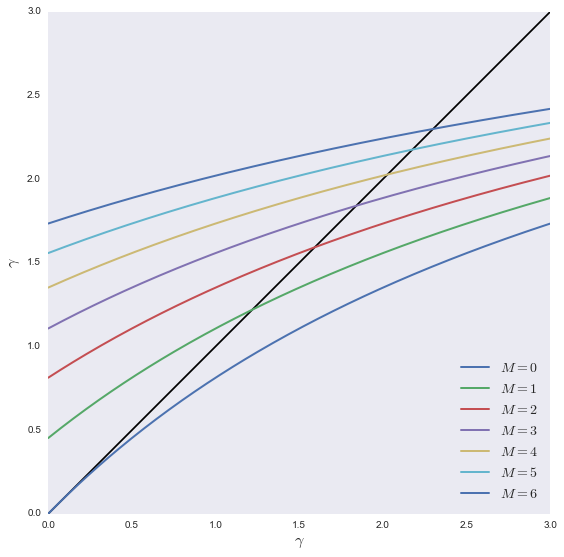

In [6]:
palette=itertools.cycle(sns.color_palette())
econ=UncertaintyTrapEcon()
rho, sig_theta, gx=econ.rho, econ.sig_theta, econ.gx #simplify names
g=np.linspace(1e-10,3,200) #gamma grid
fig, ax=plt.subplots(figsize=(9,9))
ax.plot(g,g,'k-') #45 degree line
for M in range(7):
    g_next=1/(rho**2/(g+M*gx)+sig_theta**2)
    label_string=r"$M={}$".format(M)
    ax.plot(g, g_next, lw=2, label=label_string, color=next(palette))
ax.legend(loc='lower right', fontsize=14)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylabel(r'$\gamma$', fontsize=16)
ax.grid()
plt.show()

In [7]:
sim_length=2000

mu_vec=np.empty(sim_length)
theta_vec=np.empty(sim_length)
gamma_vec=np.empty(sim_length)
X_vec=np.empty(sim_length)
M_vec=np.empty(sim_length)

mu_vec[0]=econ.mu
gamma_vec[0]=econ.gamma
theta_vec[0]=0

w_shocks=np.random.randn(sim_length)

for t in range(sim_length-1):
    X, M=econ.gen_aggregates()
    X_vec[t]=X
    M_vec[t]=M
    
    econ.update_beliefs(X, M)
    econ.update_theta(w_shocks[t])
    
    mu_vec[t+1]=econ.mu
    gamma_vec[t+1]=econ.gamma
    theta_vec[t+1]=econ.theta
    
#record final values of aggregates
X, M=econ.gen_aggregates()
X_vec[-1]=X
M_vec[-1]=M

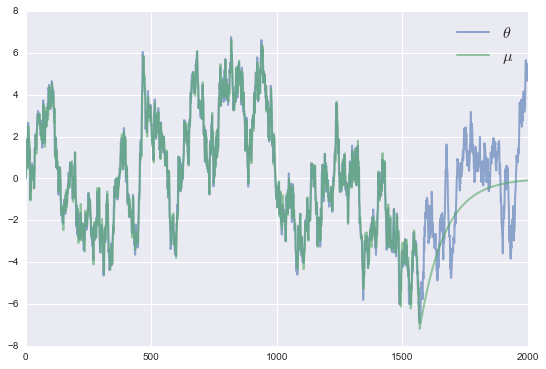

In [8]:
fig, ax=plt.subplots(figsize=(9,6))
ax.plot(range(sim_length), theta_vec, alpha=0.6, lw=2, label=r'$\theta$')
ax.plot(range(sim_length), mu_vec, alpha=0.6, lw=2, label=r'$\mu$')
ax.legend(fontsize=16)
plt.show()

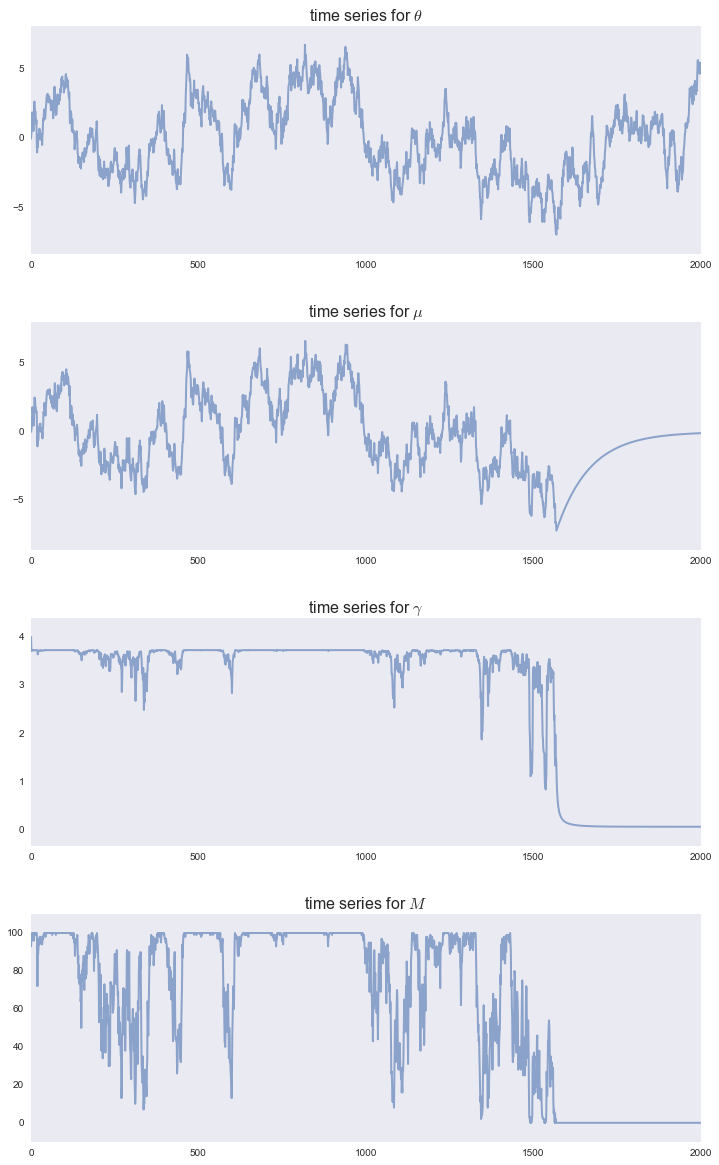

In [10]:
fig, axes=plt.subplots(4,1,figsize=(12, 20))
#add some spacing
fig.subplots_adjust(hspace=0.3)

series=(theta_vec, mu_vec,gamma_vec, M_vec)
names=r'$\theta$', r'$\mu$', r'$\gamma$', r'$M$'

for ax, vals, name in zip(axes, series, names):
    #determine suitable y limits
    s_max, s_min=max(vals), min(vals)
    s_range=s_max-s_min
    y_max=s_max+s_range*0.1
    y_min=s_min-s_range*0.1
    ax.set_ylim(y_min, y_max)
    #plot series
    ax.plot(range(sim_length), vals, alpha=0.6, lw=2)
    ax.set_title("time series for {}".format(name), fontsize=16)
    ax.grid()

plt.show()